# Whistle Detection with Continuous Kernel Convolutional Networks

In [1]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git init
    !git remote add origin https://github.com/neverorfrog/whistlenet.git
    !git pull origin main
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit install

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 1558, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 1558 (delta 208), reused 259 (delta 108), pack-reused 1162 (from 1)
Receiving objects: 100% (1558/1558), 24.90 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (701/701), done.
From https://github.com/neverorfrog/whistlenet
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin

## Config Loading

In [2]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
from whistlenet.core.utils import project_root

config_path = os.path.join(project_root(), "config","whistle_config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

## Dataset Preparation

The dataset has already been uploaded to google drive. The labelling was executed by hand by using Audacity. The processing was done as such:
- Read every single .wav audio file with librosa
- Do frequency analysis
- Extract frequency associated amplitudes for every window

This is an example of frequency plot. The highlited windows are whistle samples.

<p align="left">
  <img src="https://github.com/neverorfrog/whistlenet/blob/main/docs/assets/image.png?raw=1" alt="Alt text" width="300"/>
</p>

Retrieving folder contents


Processing file 1gD9erERi2wlDbt9sabNEEa6oM2SJ4EaO test_data.dat
Processing file 1M3zGKVEJlR7C8CikuyExgSCSMT4cKFk0 train_data.dat
Processing file 1W4zFpJ6kFOy3jQdrBugE8j1NH6zNayVu val_data.dat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1gD9erERi2wlDbt9sabNEEa6oM2SJ4EaO
From (redirected): https://drive.google.com/uc?id=1gD9erERi2wlDbt9sabNEEa6oM2SJ4EaO&confirm=t&uuid=1a151efc-12e0-4430-95a0-44785973bb5e
To: /content/data/whistle/saved/naodevils/test_data.dat
100%|██████████| 901M/901M [00:15<00:00, 57.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1M3zGKVEJlR7C8CikuyExgSCSMT4cKFk0
From (redirected): https://drive.google.com/uc?id=1M3zGKVEJlR7C8CikuyExgSCSMT4cKFk0&confirm=t&uuid=2c669064-f805-4dc1-a391-81ce0a9a317c
To: /content/data/whistle/saved/naodevils/train_data.dat
100%|██████████| 3.00G/3.00G [00:33<00:00, 88.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1W4zFpJ6kFOy3jQdrBugE8j1NH6zNayVu
From (redirected): https://drive.google.com/uc?id=1W4zFpJ6kFOy3jQdrBugE8j1NH6zNayVu&confirm=t&uuid=214840ab-4f5f-46

DATA LOADED!

N Examples: 490053
N Classes: 2
Classes: [0. 1.]
 - Class 0: 273375 (55.784782462305095)
 - Class 1: 216678 (44.2152175376949)


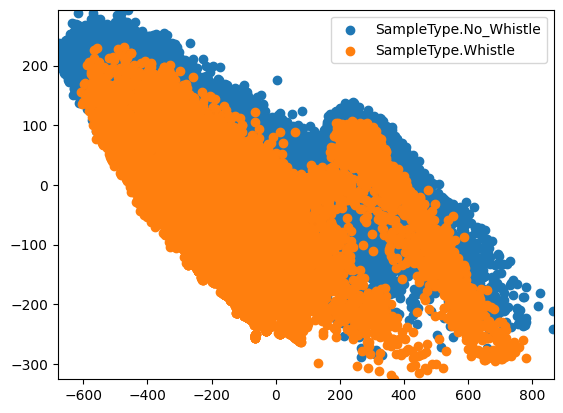

In [3]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType
import gdown

download_path = os.path.join(dataset_config.download_folder, dataset_config.name)
gdown.download_folder(
   dataset_config.drive_url, output=download_path
)

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

In [4]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer
from whistlenet.core.hpo import hpo

hpo(whistlenet_config, dataset)
model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(model, dataset)
trainer.test(model, dataset)

Starting a new hyperparameter optimization study...


[I 2025-02-03 09:57:27,553] A new study created in memory with name: whistlenet_hpo
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Starting a new trial...
Trial number: 0
Learning rate: 0.000722585541407192
Hidden Channels: 32
Kernel Hidden Channels: 24
Kernel Size: 15
Kernel Activation: ActivationFunction.LeakyReLU


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type              | Params | Mode 
---------------------------------------------------------------
0  | train_f1        | BinaryF1Score     | 0      | train
1  | train_precision | BinaryPrecision   | 0      | train
2  | train_recall    | BinaryRecall      | 0      | train
3  | train_accuracy  | BinaryAccuracy    | 0      | train
4  | val_f1          | BinaryF1Score     | 0      | train
5  | val_precision   | BinaryPrecision   | 0      | train
6  | val_recall      | BinaryRecall      | 0      | train
7  | val_accuracy    | BinaryAccuracy    | 0      | train
8  | test_f1         | BinaryF1Score     | 0      | train
9  | test_precision  | BinaryPrecision   | 0      | train
10 | test_recall     | BinaryRecall      | 0      | train
11 | test_accuracy   | BinaryAccuracy    | 0      | train
12 | backbone        | Sequential        | 5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
[I 2025-02-03 10:01:20,771] Trial 0 finished with value: 0.04235367104411125 and parameters: {'lr': 0.000722585541407192, 'hidden_channels': 32, 'kernel_hidden_channels': 24, 'kernel_size': 15, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.04235367104411125.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type              | Params | Mode 
-----------

Trial 0 finished with value 0.04235367104411125
Starting a new trial...
Trial number: 1
Learning rate: 0.0003560309772832719
Hidden Channels: 16
Kernel Hidden Channels: 32
Kernel Size: 27
Kernel Activation: ActivationFunction.Sine


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
[I 2025-02-03 10:05:15,617] Trial 1 finished with value: 0.03459364175796509 and parameters: {'lr': 0.0003560309772832719, 'hidden_channels': 16, 'kernel_hidden_channels': 32, 'kernel_size': 27, 'activation': 'Sine'}. Best is trial 1 with value: 0.03459364175796509.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type              | Params | Mode 
---------------

Trial 1 finished with value 0.03459364175796509
Starting a new trial...
Trial number: 2
Learning rate: 0.00014475183475644437
Hidden Channels: 16
Kernel Hidden Channels: 24
Kernel Size: 35
Kernel Activation: ActivationFunction.ReLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
[I 2025-02-03 10:09:02,378] Trial 2 finished with value: 0.03359892964363098 and parameters: {'lr': 0.00014475183475644437, 'hidden_channels': 16, 'kernel_hidden_channels': 24, 'kernel_size': 35, 'activation': 'ReLU'}. Best is trial 2 with value: 0.03359892964363098.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type              | Params | Mode 
--------------

Trial 2 finished with value 0.03359892964363098
Starting a new trial...
Trial number: 3
Learning rate: 0.00019885716576361546
Hidden Channels: 24
Kernel Hidden Channels: 32
Kernel Size: 35
Kernel Activation: ActivationFunction.LeakyReLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
[I 2025-02-03 10:12:47,509] Trial 3 finished with value: 0.029866399243474007 and parameters: {'lr': 0.00019885716576361546, 'hidden_channels': 24, 'kernel_hidden_channels': 32, 'kernel_size': 35, 'activation': 'LeakyReLU'}. Best is trial 3 with value: 0.029866399243474007.


Trial 3 finished with value 0.029866399243474007
Hyperparameter optimization completed.
Best hyperparameters found:
          Learning rate: 0.00019885716576361546
          Hidden Channels: 24
          Kernel Hidden CHannels: 32
          Kernel Size: 35
          Kernel Activation: LeakyReLU


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name            | Type              | Params | Mode 
---------------------------------------------------------------
0  | train_f1        | BinaryF1Score     | 0      | train
1  | train_precision | BinaryPrecision   | 0      | train
2  | train_recall    | BinaryRecall      | 0      | train
3  | train_accuracy  | BinaryAccuracy    | 0      | train
4  | val_f1          | BinaryF1Score     | 0      | train
5  | val_precision   | BinaryPrecision   | 0      | train
6  | val_reca

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.031
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.031


Model saved to ckpt/ckconv/ckconv


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-06. New best score: 0.030
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 1e-06. New best score: 0.030


Model saved to ckpt/ckconv/ckconv


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-06. New best score: 0.028
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 1e-06. New best score: 0.028


Model saved to ckpt/ckconv/ckconv


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-06. New best score: 0.027
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 1e-06. New best score: 0.027


Model saved to ckpt/ckconv/ckconv


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-06. New best score: 0.025
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 1e-06. New best score: 0.025


Model saved to ckpt/ckconv/ckconv


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 5 records. Best score: 0.025. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.025. Signaling Trainer to stop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.983322024345398     │
│       test_f1_epoch       │    0.8387435078620911     │
│      test_loss_epoch      │    0.05705179646611214    │
│   test_precision_epoch    │    0.7499706745147705     │
└───────────────────────────┴───────────────────────────┘